# Sentiment Analysis of Yelp Reviews
In this project, we'll develop a Sentiment Analysis model to predict if a review is positive or negative. Sentiment analysis is a field within Natural Language Processing (NLP) concerned with identifying and classifying subjective opinions from text. Sentiment analysis ranges from detecting emotions (happiness, anger, etc.) to intent (opinions, complaints, feedbacks, etc.). In its simplest form, sentiment analysis assigns a polarity (positive, negative, neutral) to a piece of text. 

The goals of this project are:
1. to assess the public perception of restaurants on Yelp through exploratory data analysis
2. to build a Sentiment Analysis model that accurately predicts the sentiment of reviews
3. to apply the model to a specific restaurant in order to reveal its key aspects that drive overall customer perception

You can download the data from [Yelp's Kaggle page](https://www.kaggle.com/datasets/yelp-dataset/yelp-dataset).

### Summary of Results
Our best model was <b>Logistic Regression</b> with a <b>balanced accuracy score of 0.95284</b>. We chose balanced accuracy score as our evaluation metric, since our dataset was imbalanced and both classes are equally important to us.

# Importing Dependencies

In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# For text cleaning
import re
import contractions

# For language detection
from polyglot.detect.base import logger
logger.setLevel("ERROR") # Turn off warning "Detector is not able to detect the language reliably."
from polyglot.detect import Detector

# For word clouds
from wordcloud import WordCloud
from nltk.corpus import stopwords
import string

# 1. Importing the Data
We'll be reading in the datasets for Yelp reviews and businesses.

In [2]:
reviews = pd.read_csv("yelp_review.csv")
display(reviews.head())
print(reviews.shape)

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0


(5261668, 9)


Below is the data dictionary for the reviews dataset taken from the [documentation](https://www.yelp.com/dataset/documentation/main).

variable|definition|datatype
--------|----------|---------
review_id|22 character unique review id|string
user_id|22 character unique user id|string
business_id|22 character business id|string
stars|star rating|integer
useful|number of useful votes received|integer
funny|number of funny votes received|integer
cool|number of cool votes received|integer
text|the review itself|string
date|date formatted YYYY-MM-DD|string

In [3]:
# No missing values
reviews.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5261668 entries, 0 to 5261667
Data columns (total 9 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   review_id    5261668 non-null  object
 1   user_id      5261668 non-null  object
 2   business_id  5261668 non-null  object
 3   stars        5261668 non-null  int64 
 4   date         5261668 non-null  object
 5   text         5261668 non-null  object
 6   useful       5261668 non-null  int64 
 7   funny        5261668 non-null  int64 
 8   cool         5261668 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 361.3+ MB


Let's now import the business data, which contains information about the businesses the reviews correspond to.

In [4]:
business = pd.read_csv("yelp_business.csv")
display(business.head())
print(business.shape)

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",NaN,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,1,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",NaN,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3.0,11,1,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2,KQPW8lFf1y5BT2MxiSZ3QA,"""Western Motor Vehicle""",NaN,"""6025 N 27th Ave, Ste 1""",Phoenix,AZ,85017,33.524903,-112.115310,1.5,18,1,Departments of Motor Vehicles;Public Services ...
3,8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",NaN,"""5000 Arizona Mills Cr, Ste 435""",Tempe,AZ,85282,33.383147,-111.964725,3.0,9,0,Sporting Goods;Shopping
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",NaN,"""581 Howe Ave""",Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...


(174567, 13)


Below is the data dictionary for the business dataset taken from the [documentation](https://www.yelp.com/dataset/documentation/main).

variable|definition|datatype
--------|----------|---------
business_id|22 character unique business id|string
name|the business's name|string
address|full address of the business|string
city|the city|string
state|2 character state code, if applicable|string
postal_code|the postal code|string
latitude|the latitude|float
longitude|the longitude|float
stars|star rating, rounded to half stars|float
review_count|number of reviews|integer
is_open|closed/open|integer
attributes|business attributes to values. note: some attribute values might be objects|object
categories|business categories|array of strings
hours|an object of key day to value hours, hours are using a 24hr clock|object

In [5]:
business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174567 entries, 0 to 174566
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   174567 non-null  object 
 1   name          174567 non-null  object 
 2   neighborhood  68015 non-null   object 
 3   address       174567 non-null  object 
 4   city          174566 non-null  object 
 5   state         174566 non-null  object 
 6   postal_code   173944 non-null  object 
 7   latitude      174566 non-null  float64
 8   longitude     174566 non-null  float64
 9   stars         174567 non-null  float64
 10  review_count  174567 non-null  int64  
 11  is_open       174567 non-null  int64  
 12  categories    174567 non-null  object 
dtypes: float64(3), int64(2), object(8)
memory usage: 17.3+ MB


In [6]:
# Null value count
business.isnull().sum()

business_id          0
name                 0
neighborhood    106552
address              0
city                 1
state                1
postal_code        623
latitude             1
longitude            1
stars                0
review_count         0
is_open              0
categories           0
dtype: int64

Columns `neighborhood` and `postal_code` have a ton of missing values. `city`, `state`, `longitude`, and `latitude` all have one missing value.

# 2. Data Cleaning

## 2.1 Filter Datasets
Let's keep only the columns in `reviews` that are useful for our analysis.

In [7]:
reviews = reviews.drop(['user_id','useful','funny','cool'],axis=1)
reviews.head()

,review_id,business_id,stars,date,text
0,vkVSCC7xljjrAI4UGfnKEQ,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...
1,n6QzIUObkYshz4dz2QRJTw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...
2,MV3CcKScW05u5LVfF6ok0g,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...
3,IXvOzsEMYtiJI0CARmj77Q,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...
4,L_9BTb55X0GDtThi6GlZ6w,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...


For `business`, the columns that have missing values are not a problem in this case, since we won't be needing them. Let's keep only the columns that are useful for our analysis.

In [8]:
business = business.drop(['address','postal_code','latitude','longitude','neighborhood'],axis=1)
business.head()

,business_id,name,city,state,stars,review_count,is_open,categories
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",Ahwatukee,AZ,4.0,22,1,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",McMurray,PA,3.0,11,1,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2,KQPW8lFf1y5BT2MxiSZ3QA,"""Western Motor Vehicle""",Phoenix,AZ,1.5,18,1,Departments of Motor Vehicles;Public Services ...
3,8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",Tempe,AZ,3.0,9,0,Sporting Goods;Shopping
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",Cuyahoga Falls,OH,3.5,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...


Since we're only interested in restaurants, let's drop rows of all other businesses.

In [9]:
# city and state are the only columns left that have null values, let's drop those rows first
business = business.dropna(subset=['city','state'])

# filter business to restaurants
mask = business['categories'].str.contains('Restaurants')
business = business[mask].reset_index(drop=True)
display(business.head())
print(business.shape)

,business_id,name,city,state,stars,review_count,is_open,categories
0,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",Cuyahoga Falls,OH,3.5,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...
1,o9eMRCWt5PkpLDE0gOPtcQ,"""Messina""",Stuttgart,BW,4.0,5,1,Italian;Restaurants
2,XOSRcvtaKc_Q5H1SAzN20A,"""East Coast Coffee""",Houston,PA,4.5,3,0,Breakfast & Brunch;Gluten-Free;Coffee & Tea;Fo...
3,fNMVV_ZX7CJSDWQGdOM8Nw,"""Showmars Government Center""",Charlotte,NC,3.5,7,1,Restaurants;American (Traditional)
4,l09JfMeQ6ynYs5MCJtrcmQ,"""Alize Catering""",Toronto,ON,3.0,12,0,Italian;French;Restaurants


(54618, 8)


Let's drop the reviews for businesses other than restaurants.

In [10]:
# business IDs of restaurants in our data
biz_list = set(business['business_id'])

# filter reviews to only restaurants
mask = reviews.apply(lambda x: True if x['business_id'] in biz_list else False, axis=1)
reviews = reviews[mask].reset_index(drop=True)
print(reviews.shape)

(3221418, 5)


In [11]:
del mask
del biz_list

## 2.2 Text Preprocessing
The reviews are currently in a corpus (collection of texts) format. We need them to be in a document-term matrix. The steps that we'll take to achieve this is as follows:
1. <b>Clean text</b>: remove unnecessary parts of the text
2. <b>Tokenize text</b>: split the text into smaller pieces
3. <b>Document-term matrix</b>: put into a matrix so a machine can read it 

### 2.2.1 Clean Text
First, let's see if there are gibberish reviews in our data.

In [12]:
reviews[reviews.text.str.len()<5]

,review_id,business_id,stars,date,text
14646,dZCbpaEgLJJGDP34kJ9ReA,P0IY-8h2q--Uiw6vKIJ3QQ,1,2013-07-29,No
45112,ZgflMPZFUmBbiZvn4BrmRg,t59EjJ_flqR75Mk2RWILAg,2,2016-11-04,O
266024,cBNr10LrIghLcpdVIugO3g,alANV-ujatCMh3vYX9H6Yg,3,2013-10-11,K
551826,pmnAcXt4z6RNEgqoVAFshQ,eVv6cnwhabK8ig5Di2hXQQ,4,2015-05-11,Dank
551827,-mbeONh_jxTOqKM6TSRgCQ,QDRFdG8gPPKL7r4yic8j7Q,4,2015-05-11,Dank
568025,VGh6dbY8gzc1btt6mmyM1g,vAUDxhbsWZKI8NJlsYwCMA,1,2015-07-12,.
727453,4Va_ahkgr-C5eE2v3dLGag,nZnebnuZDiBJxEMDxcDF-w,5,2016-05-15,Yelp
843702,R4jyGsQ3iBMCCIIaqC0bMg,aMzlJdISuBKF0DD92reeQQ,4,2012-12-01,gut
885179,2r8pT0z4y5cMZ7zuTRGokw,sHFGkdx1ARhPT0efU70urA,5,2012-06-15,Good
1029725,Ywb3NLF4Vd6F2kzKilmYJg,QJyFT9MJ-34LZhkB1nMOsg,2,2016-07-21,Bien


We see that there are quite a few one-character reviews, and that some reviews are in a language other than English. Let's drop reviews whose text has fewer than 3 characters. This seems to be the best choice, since there doesn't seem to be a clear trend between reviews with < 3 characters and ratings (except for a couple reviews saying "No"). Especially for 1-character reviews, some have high ratings and some have low ratings. I believe this will affect model accuracy, so it's best to drop these reviews.

In [13]:
# Drop reviews with less than 3 characters
reviews = reviews[reviews['text'].str.len()>=3].reset_index(drop=True)
print(reviews.shape)

(3221403, 5)


We'll convert the text to lowercase and remove punctuation, numbers, and newlines. We'll also expand contractions, which is critical for when we filter out stop words. It's best to clean the text before language detection.

In [14]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s\']", ' ', text) # punctuation, replace with space in case of "example...but"
                                           # we can't join ' yet because i've -> i ve
                                           # and contractions can't convert it
    text = re.sub(r'[_\d]', '', text) # underscore and digits
    text = re.sub(r'\n', ' ', text) # newline
    text = contractions.fix(text) # expand contractions
    text = re.sub(r"[\']", '', text) # now we can get rid of '

    return text

reviews.loc[:,'text'] = reviews.loc[:,'text'].apply(lambda x: clean_text(x))

Let's now filter for English reviews.

In [15]:
unknown_lang = set()
def isEnglish(text, index):
    x = Detector(text, quiet=True).language.code
    if x=='en':
        return True
    elif x=='un':
        unknown_lang.add(index) # keep track of index for texts of unknown language
        print(index, text, "\n")
    return False
#     try:
#         x = Detector(text).language.code
#         if x=='en':
#             return True
#         return False
#     except:
#         x="error"
#         print(index,"\n",text,"\n")

reviews['isEnglish'] = reviews.apply(lambda x: isEnglish(x['text'], x.name),axis=1)
print("---------\n{} English reviews".format(reviews['isEnglish'].sum()))

1421295 excellent family style italian  

1980817 butterfinger blast  mmmmmm    

2531310 animal style ftw  

2767998 az biltmore resort     always classic  always classy  

2897994 super gemüdlich und nette bedienung sehr lecker nur leider hat das etwas abgenommen was die homo szene angeht mann erkennt es kaum  fbaddontelno  height px  important   white space  nowrap  important   background color   ffff   

3131130 animal style  

---------
3179040 English reviews


We see that the language of most of the reviews that the language detector couldn't detect is English. Let's correct the label of these reviews and filter `reviews` to English ones only.

In [16]:
# drop index of non-English review
unknown_lang.remove(2897994)

# change isEnglish to True for English reviews the detector couldn't decipher the language of
reviews.loc[list(unknown_lang), 'isEnglish'] = True

# filter reviews to English ones only and drop isEnglish col
reviews = reviews[reviews['isEnglish']].drop('isEnglish',axis=1).reset_index(drop=True)
print(reviews.shape)

(3179045, 5)


In [17]:
del unknown_lang

In [18]:
# We'll need this later for analysis of a specific restaurant

with open('reviews_cleaned_w_3_stars.pkl','wb') as f:
    pickle.dump(reviews, f)

### 2.2.2 Tokenize Text & Document-Term Matrix
<b>Tokenization</b>: split text into smaller pieces, a.k.a. token. The most common token size is a word. It can also be a bi-gram.

After tokenization, we can filter out the stop words, which are words with very little meaning, since they won't add much meaning for the machine to process. We'll be left with a bag of words model (a simple format that ignores order). 

We'll then create a DataFrame where each row is a different review and each column is a different word. The values are word counts.

We can do all this at once using `CountVectorizer`, which converts a collection of text documents to a matrix of token counts. 

In [19]:
# We'll come back to creating this later at sentiment analysis step in the next notebook

# from sklearn.feature_extraction.text import CountVectorizer

# cv = CountVectorizer(vocabulary=list(vocab))
# rev_cv = cv.fit_transform(reviews['text']) # Learn the vocabulary dictionary and return document-term matrix
# rev_dtm = pd.DataFrame(rev_cv.toarray(), columns=cv.get_feature_names())
# rev_dtm

# 3. Exploratory Data Analysis
Remember that our main goal is to be able to predict if a review is positive or negative. We'll be utilizing `stars` to categorize our reviews as either positive or negative. Let's take a look at the distribution of `stars` in our `reviews` dataset.

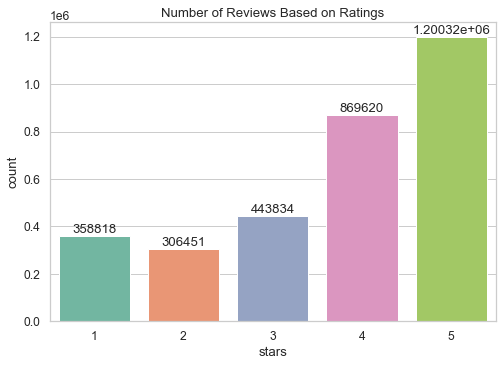

In [20]:
plt.rcParams['figure.figsize'] = [8,5.5]
sns.set(font_scale=1.1)
sns.set_style("whitegrid")

ax = sns.countplot(data=reviews, x='stars', palette='Set2')
ax.bar_label(ax.containers[0])
ax.set_title("Number of Reviews Based on Ratings")

plt.show()

In [21]:
del ax

We see that 5-star reviews are the most popular and that suprisingly, 3-star reviews are more popular than 1- or 2-star reviews. We would think that most customers leave a review when they were either highly satisfied or highly disappointed by the restaurant. This is interesting to see, but the number of 3-star reviews is not that significantly higher than the lower-star reviews. 

It would make sense to classify a 5- or 4-star review as positive and a 1- or 2-star review as negative. A 3-star review is neutral. In NLP, a neutral statement doesn't involve emotion, and those 3-star reviews likely wouldn't be like that. For the project purposes, we'll drop 3-star reviews, since these reviews most likely contain a mix of positive and negative language. In some cases, these reviews may even be exclusively positive or negative, and the customer possibly didn't think it was the worst or best restaurant they have dined in, but it's not reflected in the text. We can see this in a few 3-star reviews below.

In [22]:
display(reviews.loc[reviews['stars']==3,'text'].head(10))
display(reviews.loc[reviews['stars']==3,'text'].tail())

6     not bad   love that there is a gluten free  ve...
8     server was a little rude   ordered the calamar...
9     wanted to check out this place due to all the ...
12    came here with my girlfriends one sunday after...
13    came here for a burger as one of my friends sa...
15    was always intrigued of this place when i pass...
16    burgers are very big portions here   definitel...
18    while looking at different restaurants in the ...
19    service is really slow here  i waited for over...
21    not sure what the hype is  but decided to give...
Name: text, dtype: object

3179032    typical american style restaurant   by that i ...
3179033    went in for a snack on a sat night    bar area...
3179041    spring rolls was pretty good  cod was a bit ra...
3179043    a small  cozy family run authentic korean rest...
3179044    really nice atmosphere and settings and very c...
Name: text, dtype: object

In [23]:
# Mix of positive and negative language
reviews.loc[8,'text']

'server was a little rude   ordered the calamari  duck confit poutine and the trout fish with miso soba   all very tasty  definitely not your typical diner '

In [24]:
# positive language, rated 3 stars
reviews.loc[16,'text']

'burgers are very big portions here   definitely order the onion ring tower to share     milkshakes are tasty  my personal favourite   the vanilla one '

In [25]:
# negative language, rated 3 stars
reviews.loc[3179033,'text']

'went in for a snack on a sat night    bar area was pretty pack  restaurant side was pretty dead    sat in the restaurant side    service was non existent as the section was dead and the server would disappear after bringing the food    typical bar food   nothing special '

Due to the above reviews, adding a neutral category or classifying 3-star reviews as either positive or negative would most likely affect model accuracy. Let's drop 3-star reviews.

In [26]:
# drop 3 star reviews
reviews = reviews[reviews['stars']!=3].reset_index(drop=True)
print(reviews.shape)

(2735211, 5)


## 3.1 Creating Target Variable: Sentiment
We can now classify reviews as either positive (1) or negative (0). Let's do this before continuing our EDA.

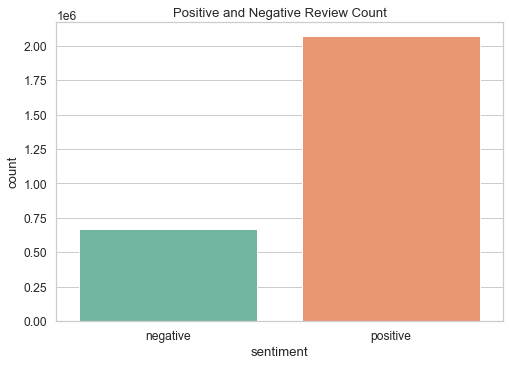

In [29]:
# initialize all reviews as positive
reviews.loc[:,'sentiment'] = 1

# change sentiment to negative for 1- and 2-star reviews
neg_mask = (reviews['stars']==1) | (reviews['stars']==2)
reviews.loc[neg_mask, 'sentiment'] = 0
del neg_mask

# plot sentiment count
sns.countplot(data=reviews, x='sentiment', palette='Set2')
plt.title("Positive and Negative Review Count")
plt.xticks([0,1],labels=['negative','positive'])

plt.show()

We see that a majority of the reviews are positive, which makes sense as we've seen earlier that most reviews have a 4- or 5-star rating. This also means that we have an imbalanced dataset, which we'll leave as is, since this seems to reflect the natural behavior of reviews. 

## 3.2 Word Clouds
Let's visualize the top words for positive and negative reviews using word clouds.

In [31]:
# We ran into a memory issue during early passes. 
# We've since fixed the issue by pickling and generating word clouds by joining text reviews together
#  instead of generating them from frequencies from DTM, which we'd have to remake again later anyway
#  after splitting the dataset into train and test sets.
# We'll still leave this chunk of code here for the exercise of it.


#############################################

# # Sampling reviews dataset

# reviews = reviews.sample(n=15000, random_state=1, ignore_index=True)

#############################################

# # Create vocabulary from the reviews

# from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords
# import string

# # add alphabet characters, auxiliary verbs, and modal auxiliary verbs to english stop words
# modal_aux_verbs = set(['has', 'have', 'had', 
#                       'does', 'do', 'did', 
#                       'be', 'am', 'is', 'are', 'was', 'were', 'being', 'been',
#                       'can', 'could', 'will', 'would', 'shall', 'should', 'may', 'might', 'must'])
# stop_words = set(stopwords.words('english')).union(set(string.ascii_lowercase)).union(modal_aux_verbs)

# vocab = set()
# def tokenize(text):
#     """
#     tokenize unique words in a text and remove stop words before adding to vocabulary
#     """
#     tokens = set(word_tokenize(text)) - stop_words
#     vocab.update(tokens)

# reviews['text'].apply(tokenize)
# len(vocab)

#############################################

# del stopwords, string

#############################################

# # Make DTM

# from sklearn.feature_extraction.text import CountVectorizer

# cv = CountVectorizer(stop_words=stop_words, ngram_range=(1,2))
# rev_cv = cv.fit_transform(reviews['text']) # Learn the vocabulary dictionary and return document-term matrix
# rev_dtm = pd.DataFrame(rev_cv.toarray(), columns=cv.get_feature_names())
# rev_dtm

# # Code to make the DTM in chunks, ended up not needing, but we'll leave it here 

# # from sklearn.feature_extraction.text import CountVectorizer

# # # split reviews['text'] into chunks
# # def split_col(col, chunk_size):
# #     if len(col) < chunk_size:
# #         yield col
        
# #     n_chunks = int(len(col) / chunk_size) # 2735211 / 10000 = 273
# #     for i in range(n_chunks+1):
# #         start_index = i * chunk_size
# #         if i==n_chunks: # remainder
# #             yield col[start_index:]
# #         else:
# #             end_index = start_index + chunk_size
# #             yield col[start_index:end_index]

# # # get dtm for every chunk
# # cv = CountVectorizer(vocabulary=list(vocab))

# # final_dtm = pd.DataFrame()
# # for chunk in split_col(reviews['text'], 10000):
# #     chunk_cv = cv.fit_transform(chunk) 
# #     chunk_dtm = pd.DataFrame(chunk_cv.toarray(), columns=cv.get_feature_names())
# #     final_dtm = pd.concat([final_dtm,chunk_dtm], ignore_index=True)

# # display(final_dtm)
# # final_dtm.shape

#############################################

#del cv, rev_cv, vocab, stop_words

#############################################

# # filter vocabulary to those that appear in more than 1 review
# rev_dtm = rev_dtm.loc[:, rev_dtm.sum(axis=0) > 1]
# rev_dtm

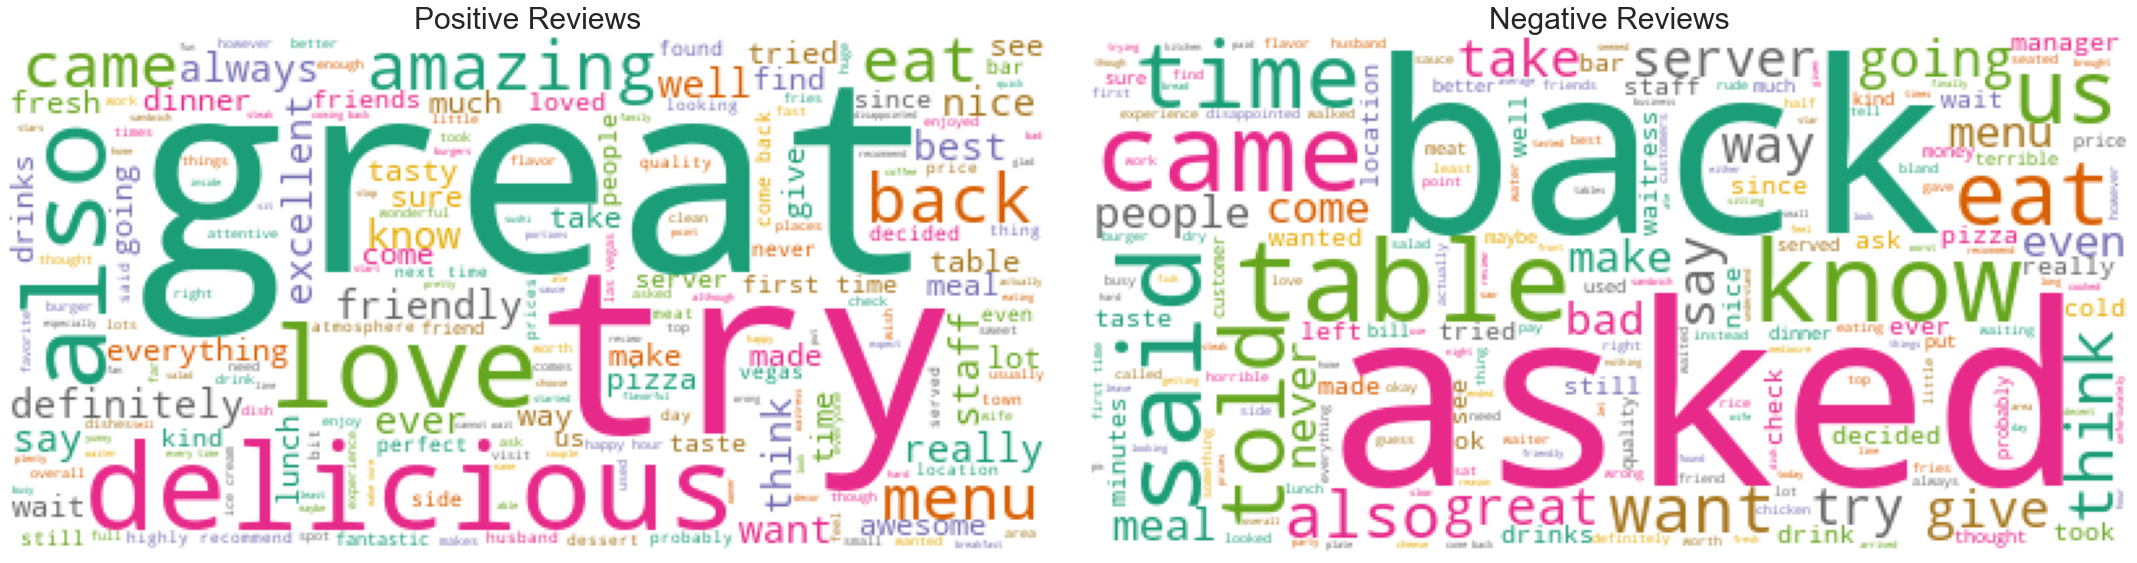

In [36]:
# Top common words between positive and negative reviews, didn't help to differentiate in word clouds
common_words = ['food','place','service',
                'like','good','one','get',
                'ordered','order','restaurant',
                'go','got','went']

# add alphabet characters, auxiliary verbs, and modal auxiliary verbs to english stop words
modal_aux_verbs = set(['has', 'have', 'had', 
                      'does', 'do', 'did', 
                      'be', 'am', 'is', 'are', 'was', 'were', 'being', 'been',
                      'can', 'could', 'will', 'would', 'shall', 'should', 'may', 'might', 'must'])
stop_words = (set(stopwords.words('english')).union(set(string.ascii_lowercase))
                                             .union(modal_aux_verbs)
                                             .union(set(common_words)))

fig = plt.figure(figsize=(30,30))
for sentiment in [0,1]:
    # Filter positive/negative reviews and get the top occurring words in them
    #index = reviews[reviews['sentiment']==sentiment].index
    #top_words_per_sentiment = rev_dtm.iloc[index].sum(axis=0).sort_values(ascending=False).drop(common_words)
    
    revs = reviews[reviews['sentiment']==sentiment]['text']
    
    # Create word cloud, want positive reviews to be on the left side
    place = (1 if sentiment else 2)
    ax = fig.add_subplot(1,2,place)
    wc = (WordCloud(background_color="white", colormap="Dark2", random_state=1, 
                    stopwords=stop_words, normalize_plurals=False)
          #.generate_from_frequencies(top_words_per_sentiment))
          .generate(" ".join(revs)))
    
    # Plot word clouds
    fig.tight_layout()
    ax.imshow(wc)
    ax.set_title(f"{'Positive' if sentiment else 'Negative'} Reviews", fontsize=30)
    ax.axis('off')

The top words in positive reviews reflect how customers enjoyed the food with compliments like <b>delicious</b> and <b>love</b>. The word cloud for negative reviews, on the other hand, may seem to be non-definitive, but we can reason that customers who write negative reviews may express opinions with varying degrees of what they didn't like at the restaurant. We can also reason from <b>time</b> and <b>minutes</b> that a lot of customers complained about a long wait. At the very least, we see words like <b>never</b>, <b>bad</b>, <b>horrible</b>, and <b>terrible</b>.

# 4. Pickling
Let's now pickle our dataframes for sentiment analysis at the next notebook.

In [ ]:
with open('reviews_cleaned.pkl', 'wb') as f:
    pickle.dump(reviews, f)
print("reviews dataset pickled")
    
with open('business_cleaned.pkl', 'wb') as f:
    pickle.dump(business, f)
print("business dataset pickled")